Primero veamos un estado y luego nos extendemos a mas estados 

In [218]:
import pandas as pd 

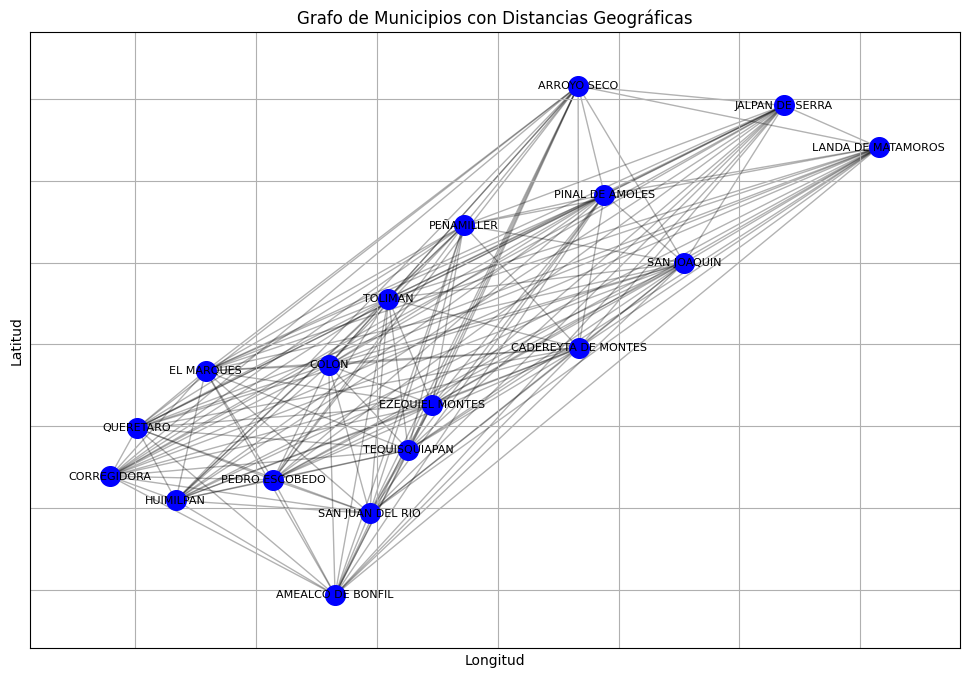

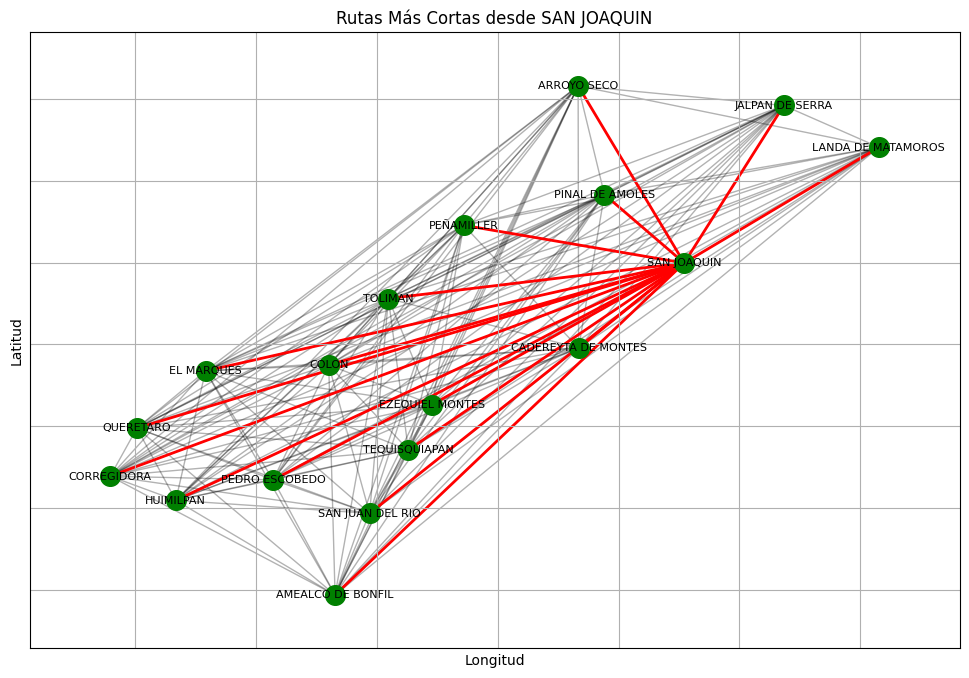

In [219]:
import pandas as pd
import networkx as nx
from geopy.distance import geodesic
import matplotlib.pyplot as plt


file_mun = r"D:\Ciencia de Datos\5to\Mates_Disc\Proyecto\2024_SEE_PRE_NAL_MUN_Queretaro_con_coordenadas.xlsx"
data_mun = pd.read_excel(file_mun)

municipios_validos = data_mun.dropna(subset=['Latitud', 'Longitud'])

grafo = nx.Graph()

# nodos del grafo
for index, row in municipios_validos.iterrows():
    grafo.add_node(
        row['MUNICIPIO'],
        votos_validos=row['NUM_VOTOS_VALIDOS'],
        coordenadas=(row['Latitud'], row['Longitud'])
    )

# Calcular distancias entre municipios y agregar aristas
municipios = municipios_validos[['MUNICIPIO', 'Latitud', 'Longitud']].values
for i in range(len(municipios)):
    for j in range(i + 1, len(municipios)):
        mun1, lat1, lon1 = municipios[i]
        mun2, lat2, lon2 = municipios[j]
        dist = geodesic((lat1, lon1), (lat2, lon2)).kilometers
        grafo.add_edge(mun1, mun2, weight=dist)

# municipio con menos votos
inicio = min(
    municipios_validos['MUNICIPIO'], 
    key=lambda x: municipios_validos.loc[municipios_validos['MUNICIPIO'] == x, 'NUM_VOTOS_VALIDOS'].values[0]
)

# Algoritmo de Dijkstra
rutas_mas_cortas = nx.single_source_dijkstra_path_length(grafo, source=inicio, weight='weight')

# grafo con las distancias
pos = {node: (data['coordenadas'][1], data['coordenadas'][0]) for node, data in grafo.nodes(data=True)}

plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(grafo, pos, node_size=200, node_color='blue')
nx.draw_networkx_edges(grafo, pos, alpha=0.3)
nx.draw_networkx_labels(grafo, pos, font_size=8, font_color='black')
plt.title('Grafo de Municipios con Distancias Geográficas')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.grid(True)
plt.show(block=True)  


shortest_paths_edges = []
for destino in grafo.nodes:
    try:
        path = nx.shortest_path(grafo, source=inicio, target=destino, weight='weight')
        shortest_paths_edges += [(path[i], path[i+1]) for i in range(len(path)-1)]
    except nx.NetworkXNoPath:
        pass

plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(grafo, pos, node_size=200, node_color='green')
nx.draw_networkx_edges(grafo, pos, alpha=0.3)
nx.draw_networkx_edges(grafo, pos, edgelist=shortest_paths_edges, edge_color='red', width=2)
nx.draw_networkx_labels(grafo, pos, font_size=8, font_color='black')
plt.title(f'Rutas Más Cortas desde {inicio}')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.grid(True)
plt.show(block=True)



Mas estados con otro tipo de enfoque solo pasado una vez por cada estado 

Ruta personalizada para Coalición PAN en AGUASCALIENTES: ['AGUASCALIENTES', 'SAN FRANCISCO DE LOS ROMO', 'PABELLON DE ARTEAGA', 'RINCON DE ROMOS', 'COSIO', 'TEPEZALA', 'ASIENTOS', 'EL LLANO', 'JESUS MARIA', 'SAN JOSE DE GRACIA', 'CALVILLO']


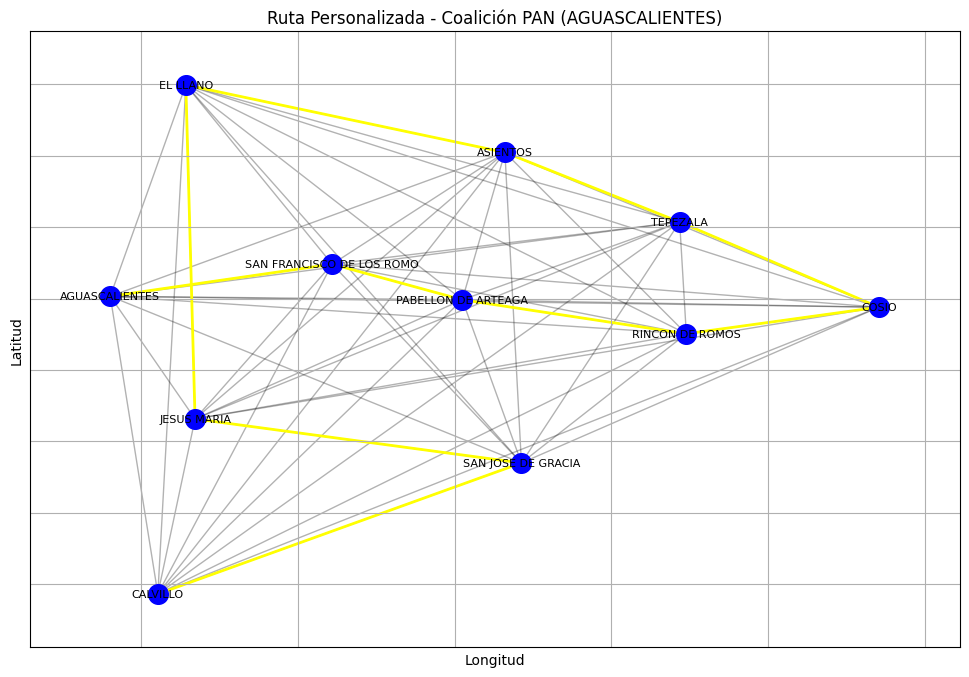

Ruta personalizada para Coalición Morena en AGUASCALIENTES: ['AGUASCALIENTES', 'SAN FRANCISCO DE LOS ROMO', 'PABELLON DE ARTEAGA', 'RINCON DE ROMOS', 'COSIO', 'TEPEZALA', 'ASIENTOS', 'EL LLANO', 'JESUS MARIA', 'SAN JOSE DE GRACIA', 'CALVILLO']


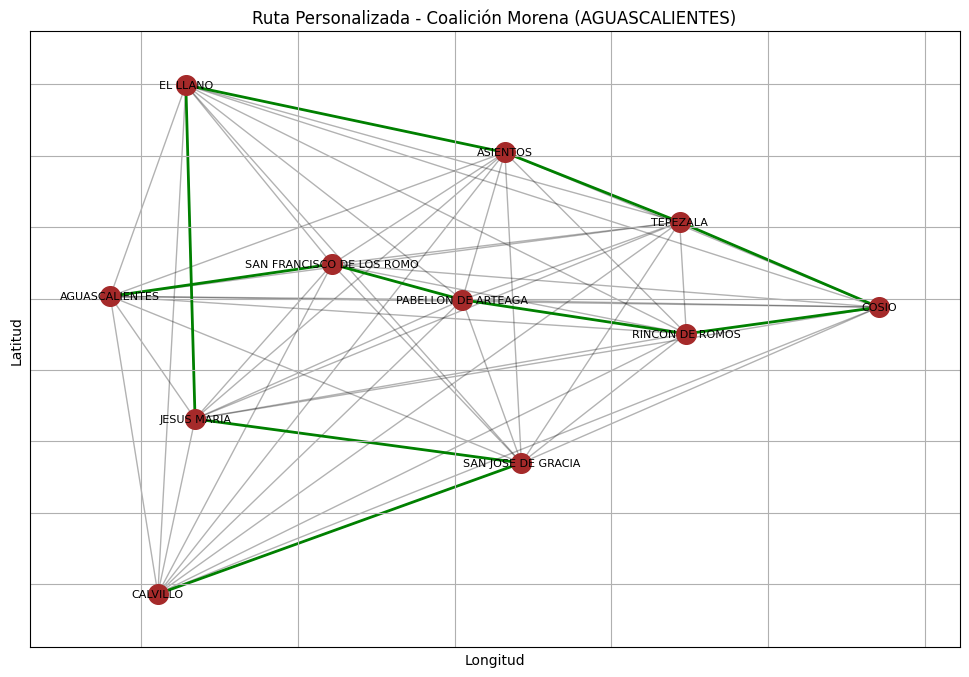

Ruta personalizada para Movimiento Ciudadano en AGUASCALIENTES: ['AGUASCALIENTES', 'SAN FRANCISCO DE LOS ROMO', 'PABELLON DE ARTEAGA', 'RINCON DE ROMOS', 'COSIO', 'TEPEZALA', 'ASIENTOS', 'EL LLANO', 'JESUS MARIA', 'SAN JOSE DE GRACIA', 'CALVILLO']


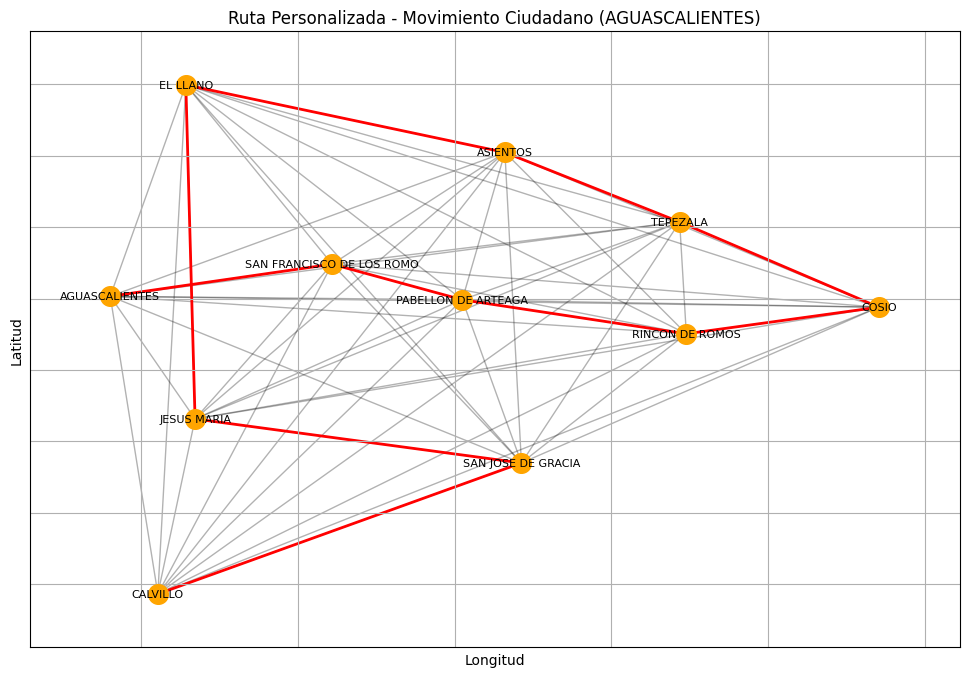

In [220]:
import pandas as pd
import networkx as nx
from geopy.distance import geodesic
import matplotlib.pyplot as plt


file_data = r"D:\Ciencia de Datos\5to\Mates_Disc\Proyecto\2024_SEE_PRE_NAL_MUN_con_coordenadas.xlsx"   
data = pd.read_excel(file_data)

data['Votos_PAN'] = (
    data['PAN'] +
    data['PRI'] +
    data['PRD'] +
    data['PAN_PRI_PRD'] +
    data['PAN_PRI'] +
    data['PAN_PRD'] +
    data['PRI_PRD']
)

data['Votos_Morena'] = (
    data['PVEM'] +
    data['PT'] +
    data['MORENA'] +
    data['PVEM_PT_MORENA'] +
    data['PVEM_PT'] +
    data['PVEM_MORENA'] +
    data['PT_MORENA']
)

data['Votos_MC'] = data['MC']

# Función para filtrar municipios por estado
def filtrar_estado(data, estado):
    data_estado = data[(data['NOMBRE_ESTADO'] == estado) & ~data['MUNICIPIO'].isnull()]
    data_estado = data_estado.dropna(subset=['Latitud', 'Longitud'])
    data_estado = data_estado[data_estado['MUNICIPIO'] != "VOTO EN EL EXTRANJERO"]
    return data_estado

# Crear un grafo
def construir_grafo(data, votos_columna):
    grafo = nx.Graph()

    # Agregar nodos y aristas con pesos según las distancias
    municipios = data[['MUNICIPIO', 'Latitud', 'Longitud', votos_columna]].values
    for i in range(len(municipios)):
        mun1, lat1, lon1, votos1 = municipios[i]
        grafo.add_node(mun1, votos=votos1, coordenadas=(lat1, lon1))
        for j in range(i + 1, len(municipios)):
            mun2, lat2, lon2, votos2 = municipios[j]
            dist = geodesic((lat1, lon1), (lat2, lon2)).kilometers
            grafo.add_edge(mun1, mun2, weight=dist)
    return grafo

# De más votos a menos votos
def ruta_personalizada(grafo, data, votos_columna):
    nodos_por_votos = sorted(data[['MUNICIPIO', votos_columna]].values, key=lambda x: -x[1])
    visitados = set()
    ruta = []
    actual = nodos_por_votos.pop(0)[0]  # Nodo más votos
    ruta.append(actual)
    visitados.add(actual)

    while nodos_por_votos:
        # Calcular las rutas más cortas desde el nodo actual
        distancias = nx.single_source_dijkstra_path_length(grafo, source=actual, weight='weight')
        
        # Buscar el próximo nodo con más votos entre los no visitados
        candidatos = [(destino, distancias[destino]) for destino, votos in nodos_por_votos if destino in distancias and destino not in visitados]
        if not candidatos:
            break
        
        # Seleccionar el candidato con menor distancia
        siguiente, _ = min(candidatos, key=lambda x: x[1])
        ruta.append(siguiente)
        visitados.add(siguiente)

        # Remover el nodo visitado de la lista de nodos por votos
        nodos_por_votos = [nodo for nodo in nodos_por_votos if nodo[0] != siguiente]
        actual = siguiente

    return ruta

#  grafo y la ruta personalizada
def visualizar_ruta(grafo, ruta, titulo, color_nodos, color_aristas):
    pos = {node: data['coordenadas'] for node, data in grafo.nodes(data=True)}
    plt.figure(figsize=(12, 8))
    nx.draw_networkx_nodes(grafo, pos, node_size=200, node_color=color_nodos)
    nx.draw_networkx_edges(grafo, pos, alpha=0.3)
    nx.draw_networkx_labels(grafo, pos, font_size=8, font_color='black')

    # Dibujar la ruta
    edges_ruta = [(ruta[i], ruta[i + 1]) for i in range(len(ruta) - 1)]
    nx.draw_networkx_edges(grafo, pos, edgelist=edges_ruta, edge_color=color_aristas, width=2)

    plt.title(titulo)
    plt.xlabel('Longitud')
    plt.ylabel('Latitud')
    plt.grid(True)
    plt.show()


def procesar_estado(data, estado):
    data_estado = filtrar_estado(data, estado)
    if data_estado.empty:
        print(f"No se encontraron municipios válidos para el estado {estado}")
        return

    coaliciones = [
        ('Coalición PAN', 'Votos_PAN', 'blue', 'yellow'),
        ('Coalición Morena', 'Votos_Morena', 'brown', 'green'),
        ('Movimiento Ciudadano', 'Votos_MC', 'orange', 'red')
    ]

    for coalicion, columna, color_nodos, color_aristas in coaliciones:
        grafo = construir_grafo(data_estado, columna)
        ruta = ruta_personalizada(grafo, data_estado, columna)
        print(f"Ruta personalizada para {coalicion} en {estado}: {ruta}")
        visualizar_ruta(grafo, ruta, f"Ruta Personalizada - {coalicion} ({estado})", color_nodos, color_aristas)

# Ejemplo de uso
estado_a_procesar = "AGUASCALIENTES"  
procesar_estado(data, estado_a_procesar)


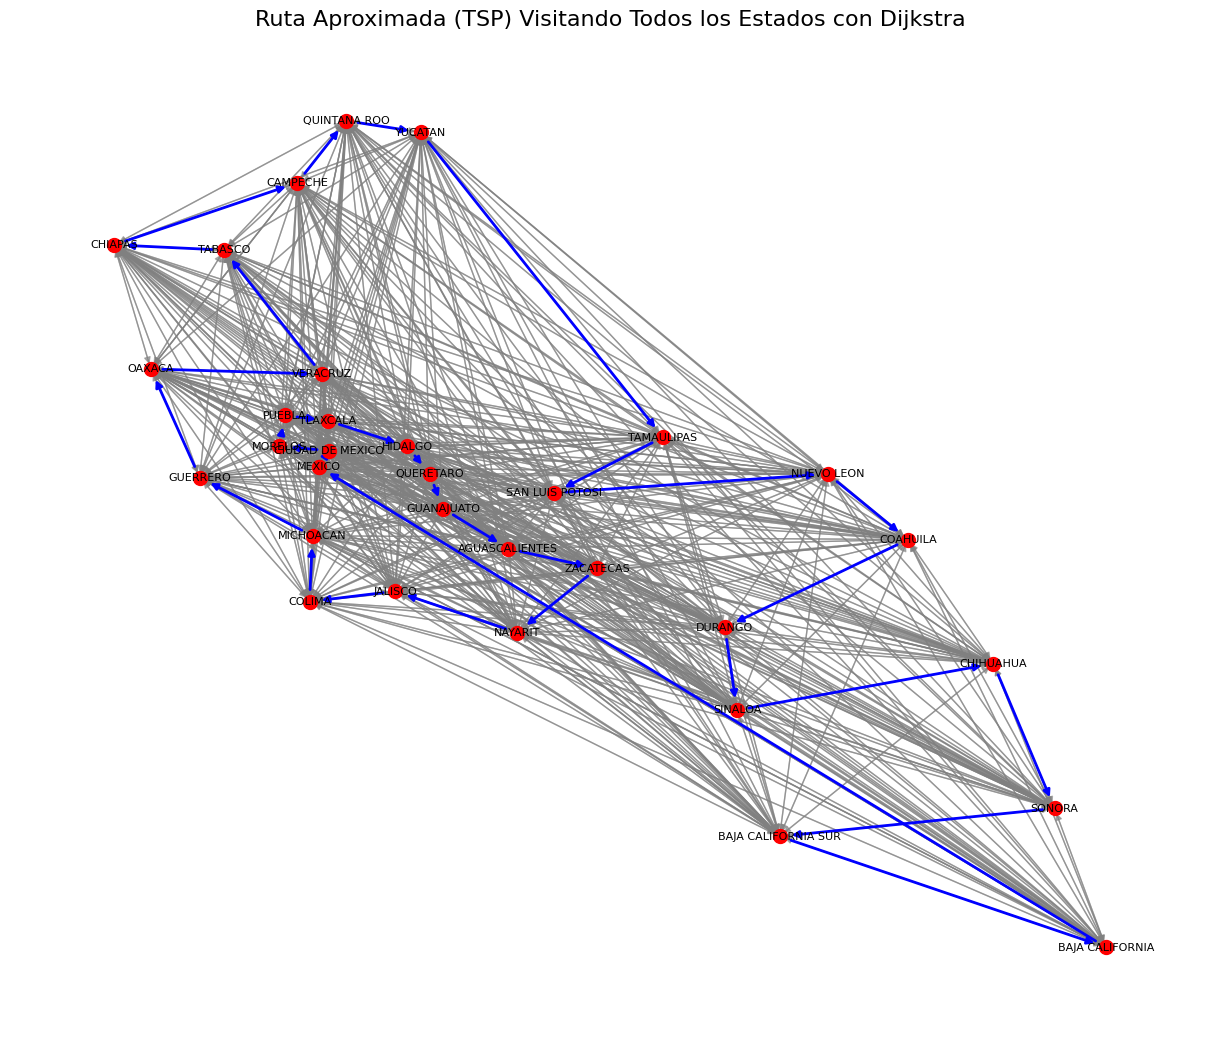

In [221]:
import pandas as pd
import networkx as nx
import numpy as np

file_path = r"D:\Ciencia de Datos\5to\Mates_Disc\Proyecto\2024_SEE_PRE_NAL_ENTCAND_with_coords.xlsx"
df = pd.ExcelFile(file_path).parse('Sheet1')

pan_columns = ['PAN_PRI_PRD']
morena_columns = ['PVEM_PT_MORENA']
mc_column = 'MC'

# Calcular los votos totales para cada coalición
df['PAN_Votes'] = df[pan_columns].sum(axis=1)
df['Morena_Votes'] = df[morena_columns].sum(axis=1)
df['MC_Votes'] = df[mc_column]

# Seleccionar la coalición a analizar (ejemplo: PAN)
df['Selected_Votes'] = df['PAN_Votes']

# Ordenar las ubicaciones por votos en orden descendente
sorted_df = df.sort_values(by='Selected_Votes', ascending=False).reset_index()

# Crear el grafo con latitud y longitud como nodos
G = nx.DiGraph()

# Agregar nodos con atributos
for idx, row in sorted_df.iterrows():
    G.add_node(idx, pos=(row['Latitud'], row['Longitud']), votes=row['Selected_Votes'])

# Agregar aristas con distancias geográficas como pesos
for i in range(len(sorted_df)):
    for j in range(len(sorted_df)):
        if i != j:
            lat1, lon1 = sorted_df.loc[i, ['Latitud', 'Longitud']]
            lat2, lon2 = sorted_df.loc[j, ['Latitud', 'Longitud']]
            # Calcular la distancia euclidiana (aproximación para áreas pequeñas)
            distance = np.sqrt((lat1 - lat2)**2 + (lon1 - lon2)**2)
            G.add_edge(i, j, weight=distance)

# Aproximación del TSP usando un enfoque basado en Dijkstra
def dijkstra_tsp_approximation(graph, start_node):
    """Aproximación de TSP utilizando el enfoque de Dijkstra."""
    visited = {start_node}
    path = [start_node]
    current_node = start_node

    while len(visited) < len(graph.nodes):
        # Encontrar el nodo no visitado más cercano
        neighbors = [(neighbor, graph[current_node][neighbor]['weight']) 
                     for neighbor in graph.neighbors(current_node) if neighbor not in visited]
        if not neighbors:
            break

        # Elegir el vecino más cercano
        next_node = min(neighbors, key=lambda x: x[1])[0]
        path.append(next_node)
        visited.add(next_node)
        current_node = next_node

    # Regresar al inicio para cerrar el ciclo
    path.append(start_node)
    return path

# Iniciar desde el nodo con más votos
start_node = sorted_df.index[0]
tsp_path = dijkstra_tsp_approximation(G, start_node)

# Crear diccionario de posiciones
positions = {idx: (row['Latitud'], row['Longitud']) for idx, row in sorted_df.iterrows()}

path_edges = [(tsp_path[i], tsp_path[i + 1]) for i in range(len(tsp_path) - 1)]

# Visualizar el grafo
plt.figure(figsize=(12, 10))
nx.draw(G, pos=positions, node_size=50, alpha=0.6, edge_color='gray', with_labels=False)
nx.draw_networkx_edges(G, pos=positions, edgelist=path_edges, edge_color='blue', width=2)
nx.draw_networkx_nodes(G, pos=positions, nodelist=tsp_path, node_size=100, node_color='red')

labels = {idx: sorted_df.loc[idx, 'NOMBRE_ESTADO'] for idx in tsp_path}
nx.draw_networkx_labels(G, pos=positions, labels=labels, font_size=8, font_color='black')

plt.title("Ruta Aproximada (TSP) Visitando Todos los Estados con Dijkstra", fontsize=16)
plt.show()

In [222]:
import pandas as pd
import networkx as nx
import numpy as np
import plotly.graph_objects as go


start_node = sorted_df.index[0]  # Nodo con más votos
end_node = sorted_df.index[-1]  # Nodo con menos votos

fig = go.Figure()

# Agregar rutas
for edge in edges_data:
    fig.add_trace(go.Scattergeo(
        lon=edge['Longitud'],
        lat=edge['Latitud'],
        mode='lines',
        line=dict(width=2, color='blue'),
        hoverinfo='none'
    ))

# Agregar nodos
nodes_df = pd.DataFrame(nodes_data)

fig.add_trace(go.Scattergeo(
    lon=nodes_df['Longitud'],
    lat=nodes_df['Latitud'],
    text=nodes_df['Estado'] + '<br>Orden: ' + nodes_df['Orden de Visita'].astype(str),
    mode='markers',
    marker=dict(size=15, color='red'),
    hoverinfo='text'  
))

# Configurar el mapa centrado en México
fig.update_layout(
    title="Ruta TSP Visitando Todos los Estados (De Mayor a Menor Aportación)",
    geo=dict(
        scope='north america',
        projection_type='mercator',
        showland=True,
        landcolor='lightgray',
        countrycolor='black',
        lonaxis=dict(range=[-118, -86]), 
        lataxis=dict(range=[14, 33])     
    ),
    showlegend=False,
    height=800,  
    width=1200  
)

fig.show()

Analisis con presupuestos 

In [223]:
import pandas as pd
import numpy as np

# Cargar los datos del archivo Excel original
file_path = r"D:\Ciencia de Datos\5to\Mates_Disc\Proyecto\2024_SEE_PRE_NAL_ENTCAND_with_coords.xlsx"
df = pd.ExcelFile(file_path).parse('Sheet1')

# Filtrar las columnas relevantes: nombres de estados, votos (coalición PAN), latitudes y longitudes
pan_columns = ['PAN_PRI_PRD']  # Ajustado según la estructura previa
df['PAN_Votes'] = df[pan_columns].sum(axis=1)
state_votes = df[['NOMBRE_ESTADO', 'PAN_Votes', 'Latitud', 'Longitud']].copy()

# Simular el orden de visita basado en votos en orden descendente (TSP)
state_votes = state_votes.sort_values(by='PAN_Votes', ascending=False).reset_index(drop=True)
state_votes['Visit_Order'] = state_votes.index + 1

# Presupuesto total a asignar
total_budget = 64679563.87

# Calcular los pesos y asignación de presupuesto
state_votes['Weight'] = state_votes['PAN_Votes'] * state_votes['Visit_Order']
total_weight = state_votes['Weight'].sum()
state_votes['Presupuesto'] = (state_votes['Weight'] / total_weight) * total_budget

# Formatear el presupuesto asignado
state_votes['Presupuesto Asignado'] = state_votes['Presupuesto'].apply(lambda x: f"${x:,.2f}")

total_row = {
    'NOMBRE_ESTADO': 'Total',
    'PAN_Votes': state_votes['PAN_Votes'].sum(),
    'Visit_Order': '',
    'Presupuesto Asignado': f"${state_votes['Presupuesto'].sum():,.2f}"
}
state_votes = pd.concat([state_votes, pd.DataFrame([total_row])], ignore_index=True)


state_votes

,NOMBRE_ESTADO,PAN_Votes,Latitud,Longitud,Visit_Order,Weight,Presupuesto,Presupuesto Asignado
0,MEXICO,2241267,19.292200,-99.653200,1,2241267.0,9.684613e+05,"$968,461.27"
1,CIUDAD DE MEXICO,1937152,19.432630,-99.133178,2,3874304.0,1.674104e+06,"$1,674,103.70"
2,JALISCO,1384825,20.333333,-103.666667,3,4154475.0,1.795167e+06,"$1,795,166.82"
3,GUANAJUATO,1103326,20.987700,-101.000000,4,4413304.0,1.907008e+06,"$1,907,007.96"
4,NUEVO LEON,888064,26.238436,-99.887300,5,4440320.0,1.918682e+06,"$1,918,681.69"
5,VERACRUZ,846842,19.333333,-96.666667,6,5081052.0,2.195545e+06,"$2,195,544.79"
6,PUEBLA,716148,18.833333,-98.000000,7,5013036.0,2.166155e+06,"$2,166,154.78"
7,COAHUILA,617208,27.333333,-102.000000,8,4937664.0,2.133586e+06,"$2,133,586.21"
8,MICHOACAN,607301,19.207098,-101.878113,9,5465709.0,2.361757e+06,"$2,361,756.76"
9,CHIHUAHUA,559690,28.500000,-106.000000,10,5596900.0,2.418445e+06,"$2,418,444.97"


In [224]:
# Crear la ruta de los estados para el grafo
positions = {idx: (row['Latitud'], row['Longitud']) for idx, row in state_votes.iterrows()}
path_edges = [(state_votes.index[i], state_votes.index[i + 1]) for i in range(len(state_votes) - 1)]

# Crear nodos y aristas para visualización
nodes_data = []
edges_data = []

# Agregar nodos al dataset para visualización
for idx, row in state_votes.iterrows():
    nodes_data.append({
        'Estado': row['NOMBRE_ESTADO'],
        'Latitud': row['Latitud'],
        'Longitud': row['Longitud'],
        'Orden de Visita': row['Visit_Order'],
        'Presupuesto': row['Presupuesto Asignado']
    })

# Agregar líneas para las rutas entre nodos
for edge in path_edges:
    lat1, lon1 = positions[edge[0]]
    lat2, lon2 = positions[edge[1]]
    edges_data.append({
        'Latitud': [lat1, lat2],
        'Longitud': [lon1, lon2],
        'line_group': f'{edge[0]}-{edge[1]}'
    })

# Crear figura interactiva con Plotly
fig = go.Figure()

# Agregar rutas
for edge in edges_data:
    fig.add_trace(go.Scattergeo(
        lon=edge['Longitud'],
        lat=edge['Latitud'],
        mode='lines',
        line=dict(width=2, color='blue'),
        hoverinfo='none'
    ))

# Agregar nodos
nodes_df = pd.DataFrame(nodes_data)
fig.add_trace(go.Scattergeo(
    lon=nodes_df['Longitud'],
    lat=nodes_df['Latitud'],
    text=nodes_df['Estado'] + '<br>Orden: ' + nodes_df['Orden de Visita'].astype(str) +
         '<br>Presupuesto: ' + nodes_df['Presupuesto'],
    mode='markers',
    marker=dict(size=10, color='red'),
    hoverinfo='text'
))

# Configurar el mapa
fig.update_layout(
    title="Ruta de Visita por Estado con Presupuesto Asignado",
    geo=dict(
        scope='north america',
        projection_type='mercator',
        showland=True,
        landcolor='lightgray',
        countrycolor='black',
        lonaxis=dict(range=[-118, -86]),  
        lataxis=dict(range=[14, 33]),
    ),
    showlegend=False,
)

fig.show()

In [225]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

def allocate_budget_and_visualize(coalition_name, budget, votes_columns):
    file_path = r"D:\Ciencia de Datos\5to\Mates_Disc\Proyecto\2024_SEE_PRE_NAL_ENTCAND_with_coords.xlsx"
    df = pd.ExcelFile(file_path).parse('Sheet1')

    # Votos totales de la coalición
    df[f'{coalition_name}_Votes'] = df[votes_columns].sum(axis=1)
    state_votes = df[['NOMBRE_ESTADO', f'{coalition_name}_Votes', 'Latitud', 'Longitud']].copy()
    state_votes.rename(columns={f'{coalition_name}_Votes': 'Votes'}, inplace=True)

    # Ordenar los estados según los votos en orden descendente
    state_votes = state_votes.sort_values(by='Votes', ascending=False).reset_index(drop=True)
    state_votes['Visit_Order'] = state_votes.index + 1

    # Calcular los pesos y asignación de presupuesto
    state_votes['Weight'] = state_votes['Votes'] * state_votes['Visit_Order']
    total_weight = state_votes['Weight'].sum()
    state_votes['Presupuesto'] = (state_votes['Weight'] / total_weight) * budget
    state_votes['Presupuesto Asignado'] = state_votes['Presupuesto'].apply(lambda x: f"${x:,.2f}")

    # Ruta de los estados para el grafo
    positions = {idx: (row['Latitud'], row['Longitud']) for idx, row in state_votes.iterrows()}
    path_edges = [(state_votes.index[i], state_votes.index[i + 1]) for i in range(len(state_votes) - 1)]

    # Nodos y aristas para visualización
    nodes_data = []
    edges_data = []

    for idx, row in state_votes.iterrows():
        nodes_data.append({
            'Estado': row['NOMBRE_ESTADO'],
            'Latitud': row['Latitud'],
            'Longitud': row['Longitud'],
            'Orden de Visita': row['Visit_Order'],
            'Presupuesto': row['Presupuesto Asignado']
        })

    for edge in path_edges:
        lat1, lon1 = positions[edge[0]]
        lat2, lon2 = positions[edge[1]]
        edges_data.append({
            'Latitud': [lat1, lat2],
            'Longitud': [lon1, lon2],
            'line_group': f'{edge[0]}-{edge[1]}'
        })

    # Crear figura interactiva con Plotly
    fig = go.Figure()

    # Agregar rutas
    for edge in edges_data:
        fig.add_trace(go.Scattergeo(
            lon=edge['Longitud'],
            lat=edge['Latitud'],
            mode='lines',
            line=dict(width=2, color='blue'),
            hoverinfo='none'
        ))

    # Agregar nodos
    nodes_df = pd.DataFrame(nodes_data)
    fig.add_trace(go.Scattergeo(
        lon=nodes_df['Longitud'],
        lat=nodes_df['Latitud'],
        text=nodes_df['Estado'] + '<br>Orden: ' + nodes_df['Orden de Visita'].astype(str) +
             '<br>Presupuesto: ' + nodes_df['Presupuesto'],
        mode='markers',
        marker=dict(size=10, color='red'),
        hoverinfo='text'
    ))

    # Configurar el mapa centrado en México
    fig.update_layout(
        title=f"Ruta de Visita por Estado con Presupuesto Asignado ({coalition_name})",
        geo=dict(
            scope='north america',
            projection_type='mercator',
            showland=True,
            landcolor='lightgray',
            countrycolor='black',
            lonaxis=dict(range=[-118, -86]),  
            lataxis=dict(range=[14, 33]),    
        ),
        showlegend=False
    )

    fig.show()

# Presupuestos y columnas para cada coalición(En base a csv del INE)
coalitions = {
    'PAN': {
        'budget': 64679563.87,
        'votes_columns': ['PAN_PRI_PRD']
    },
    'MORENA': {
        'budget': 39369772.39,
        'votes_columns': ['PVEM_PT_MORENA']
    },
    'Movimiento Ciudadano': {
        'budget': 2960184.66,
        'votes_columns': ['MC']
    }
}

# Visualización para cada coalición
for coalition, details in coalitions.items():
    allocate_budget_and_visualize(coalition, details['budget'], details['votes_columns'])


In [226]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

def allocate_budget_and_visualize(coalition_name, budget, votes_columns, file_path=r"D:\Ciencia de Datos\5to\Mates_Disc\Proyecto\2024_SEE_PRE_NAL_ENTCAND_with_coords.xlsx"):
    df = pd.ExcelFile(file_path).parse('Sheet1')

    # Votos totales de la coalición
    df[f'{coalition_name}_Votes'] = df[votes_columns].sum(axis=1)
    state_votes = df[['NOMBRE_ESTADO', f'{coalition_name}_Votes', 'Latitud', 'Longitud']].copy()
    state_votes.rename(columns={f'{coalition_name}_Votes': 'Votes'}, inplace=True)

    # Ordenar los estados según los votos en orden descendente
    state_votes = state_votes.sort_values(by='Votes', ascending=False).reset_index(drop=True)
    state_votes['Visit_Order'] = state_votes.index + 1

    # Calcular los pesos y asignación de presupuesto
    state_votes['Weight'] = state_votes['Votes'] * state_votes['Visit_Order']
    total_weight = state_votes['Weight'].sum()
    state_votes['Presupuesto'] = (state_votes['Weight'] / total_weight) * budget
    state_votes['Presupuesto Asignado'] = state_votes['Presupuesto'].apply(lambda x: f"${x:,.2f}")

    # Ruta de los estados para el grafo
    positions = {idx: (row['Latitud'], row['Longitud']) for idx, row in state_votes.iterrows()}
    path_edges = [(state_votes.index[i], state_votes.index[i + 1]) for i in range(len(state_votes) - 1)]

    # Nodos y aristas para visualización
    nodes_data = []
    edges_data = []

    for idx, row in state_votes.iterrows():
        nodes_data.append({
            'Estado': row['NOMBRE_ESTADO'],
            'Latitud': row['Latitud'],
            'Longitud': row['Longitud'],
            'Orden de Visita': row['Visit_Order'],
            'Presupuesto': row['Presupuesto Asignado']
        })

    for edge in path_edges:
        lat1, lon1 = positions[edge[0]]
        lat2, lon2 = positions[edge[1]]
        edges_data.append({
            'Latitud': [lat1, lat2],
            'Longitud': [lon1, lon2],
            'line_group': f'{edge[0]}-{edge[1]}'
        })

    # Crear figura interactiva con Plotly
    fig = go.Figure()

    # Agregar rutas
    for edge in edges_data:
        fig.add_trace(go.Scattergeo(
            lon=edge['Longitud'],
            lat=edge['Latitud'],
            mode='lines',
            line=dict(width=2, color='blue'),
            hoverinfo='none'
        ))

    # Agregar nodos
    nodes_df = pd.DataFrame(nodes_data)
    fig.add_trace(go.Scattergeo(
        lon=nodes_df['Longitud'],
        lat=nodes_df['Latitud'],
        text=nodes_df['Estado'] + '<br>Orden: ' + nodes_df['Orden de Visita'].astype(str) +
             '<br>Presupuesto: ' + nodes_df['Presupuesto'],
        mode='markers',
        marker=dict(size=10, color='red'),
        hoverinfo='text'
    ))

    # Configurar el mapa centrado en México
    fig.update_layout(
        title=f"Ruta de Visita por Estado con Presupuesto Asignado ({coalition_name})",
        geo=dict(
            scope='north america',
            projection_type='mercator',
            showland=True,
            landcolor='lightgray',
            countrycolor='black',
            lonaxis=dict(range=[-118, -86]),  
            lataxis=dict(range=[14, 33]),    
        ),
        showlegend=False
    )

    fig.show()

# Presupuestos y columnas para cada coalición
coalitions = {
    'PAN': {
        'budget': 64679563.87,
        'votes_columns': ['PAN_PRI_PRD']
    },
    'MORENA': {
        'budget': 39369772.39,
        'votes_columns': ['PVEM_PT_MORENA']
    },
    'Movimiento Ciudadano': {
        'budget': 2960184.66,
        'votes_columns': ['MC']
    }
}

# Coalicion a analizar 
print("Coaliciones disponibles:", ', '.join(coalitions.keys()))
selected_coalition = input("Ingrese el nombre de la coalición que desea visualizar: ")

if selected_coalition in coalitions:
    details = coalitions[selected_coalition]
    allocate_budget_and_visualize(selected_coalition, details['budget'], details['votes_columns'])
else:
    print(f"La coalición '{selected_coalition}' no está disponible. Por favor, inténtelo de nuevo.")

Coaliciones disponibles: PAN, MORENA, Movimiento Ciudadano


Ahora por estado

In [227]:
import pandas as pd

# Cargar datos
file_data = r"D:\Ciencia de Datos\5to\Mates_Disc\Proyecto\Queretaro\2024_SEE_PRE_NAL_MUN_Queretaro_con_coordenadas.xlsx"
data = pd.read_excel(file_data)
state_votes 

# Crear columnas agrupadas según las coaliciones
data['Votos_PAN'] = (
    data['PAN'] +
    data['PRI'] +
    data['PRD'] +
    data['PAN_PRI_PRD'] +
    data['PAN_PRI'] +
    data['PAN_PRD'] +
    data['PRI_PRD']
)

data['Votos_Morena'] = (
    data['PVEM'] +
    data['PT'] +
    data['MORENA'] +
    data['PVEM_PT_MORENA'] +
    data['PVEM_PT'] +
    data['PVEM_MORENA'] +
    data['PT_MORENA']
)

data['Votos_MC'] = data['MC']

# Función para filtrar municipios por estado
def filtrar_estado(data, estado):
    data_estado = data[(data['NOMBRE_ESTADO'] == estado) & ~data['MUNICIPIO'].isnull()]
    data_estado = data_estado.dropna(subset=['Latitud', 'Longitud'])
    data_estado = data_estado[data_estado['MUNICIPIO'] != "VOTO EN EL EXTRANJERO"]
    return data_estado

# Función para asignar presupuesto a los municipios
def asignar_presupuesto(data_estado, state_votes, estado, votos_columna):
    # Obtener el presupuesto asignado al estado para la coalición
    presupuesto_total = state_votes.loc[state_votes['NOMBRE_ESTADO'] == estado, 'Presupuesto Asignado'].values[0]
    presupuesto_total = float(presupuesto_total.replace('$', '').replace(',', ''))  # Convertir a número
    
    # Ordenar los municipios por prioridad de visita (de más votos a menos votos)
    data_estado = data_estado.sort_values(by=votos_columna, ascending=False).reset_index(drop=True)
    
    # Asignar el presupuesto ponderado
    total_votos = data_estado[votos_columna].sum()
    data_estado['Presupuesto Ponderado'] = data_estado[votos_columna] / total_votos * presupuesto_total
    data_estado['Presupuesto Ponderado'] = data_estado['Presupuesto Ponderado'].apply(
        lambda x: f"${x:,.2f}"  # Aplicar formato monetario
    )
    
    return data_estado[['MUNICIPIO', votos_columna, 'Presupuesto Ponderado']]

# Procesar un estado
def procesar_estado_presupuesto(data, state_votes, estado, votos_columna):
    # Filtrar municipios del estado
    data_estado = filtrar_estado(data, estado)
    if data_estado.empty:
        print(f"No se encontraron municipios válidos para el estado {estado}")
        return None

    # Asignar presupuesto a los municipios
    presupuesto_asignado = asignar_presupuesto(data_estado, state_votes, estado, votos_columna)
    return presupuesto_asignado

# Ejemplo de uso
estado_a_procesar = "QUERETARO"  # Cambia el estado según sea necesario
coalicion = "Votos_PAN"  # Cambia la columna de votos según la coalición

# Procesar el estado
presupuesto_asignado = procesar_estado_presupuesto(data, state_votes, estado_a_procesar, coalicion)

presupuesto_asignado

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Ciencia de Datos\\5to\\Mates_Disc\\Proyecto\\Queretaro\\2024_SEE_PRE_NAL_MUN_Queretaro_con_coordenadas.xlsx'

In [ ]:
import pandas as pd
import networkx as nx
from geopy.distance import geodesic
import plotly.graph_objects as go
file_data = r"D:\Ciencia de Datos\5to\Mates_Disc\Proyecto\2024_SEE_PRE_NAL_MUN_con_coordenadas.xlsx"
data = pd.read_excel(file_data)

# Coaliciones
data['Votos_PAN'] = (
    data['PAN'] +
    data['PRI'] +
    data['PRD'] +
    data['PAN_PRI_PRD'] +
    data['PAN_PRI'] +
    data['PAN_PRD'] +
    data['PRI_PRD']
)

data['Votos_Morena'] = (
    data['PVEM'] +
    data['PT'] +
    data['MORENA'] +
    data['PVEM_PT_MORENA'] +
    data['PVEM_PT'] +
    data['PVEM_MORENA'] +
    data['PT_MORENA']
)

data['Votos_MC'] = data['MC']

# Filtrar municipios por estado
def filtrar_estado(data, estado):
    data_estado = data[(data['NOMBRE_ESTADO'] == estado) & ~data['MUNICIPIO'].isnull()]
    data_estado = data_estado.dropna(subset=['Latitud', 'Longitud'])
    data_estado = data_estado[data_estado['MUNICIPIO'] != "VOTO EN EL EXTRANJERO"]
    return data_estado

# Crear grafo
def construir_grafo(data, votos_columna):
    grafo = nx.Graph()
    municipios = data[['MUNICIPIO', 'Latitud', 'Longitud', votos_columna]].values
    for i in range(len(municipios)):
        mun1, lat1, lon1, votos1 = municipios[i]
        grafo.add_node(mun1, votos=votos1, coordenadas=(lat1, lon1))
        for j in range(i + 1, len(municipios)):
            mun2, lat2, lon2, votos2 = municipios[j]
            dist = geodesic((lat1, lon1), (lat2, lon2)).kilometers
            grafo.add_edge(mun1, mun2, weight=dist)
    return grafo

# Ruta personalizada
def ruta_personalizada(grafo, data, votos_columna):
    nodos_por_votos = sorted(data[['MUNICIPIO', votos_columna]].values, key=lambda x: -x[1])
    visitados = set()
    ruta = []
    actual = nodos_por_votos.pop(0)[0]
    ruta.append(actual)
    visitados.add(actual)
    
    while nodos_por_votos:
        distancias = nx.single_source_dijkstra_path_length(grafo, source=actual, weight='weight')
        candidatos = [(destino, distancias[destino]) for destino, votos in nodos_por_votos if destino in distancias and destino not in visitados]
        if not candidatos:
            break
        siguiente, _ = min(candidatos, key=lambda x: x[1])
        ruta.append(siguiente)
        visitados.add(siguiente)
        nodos_por_votos = [nodo for nodo in nodos_por_votos if nodo[0] != siguiente]
        actual = siguiente
    return ruta

# Visualización interactiva
def visualizar_interactivo(grafo, ruta, presupuesto_asignado, titulo, color_nodos, color_aristas):
    pos = {node: data['coordenadas'] for node, data in grafo.nodes(data=True)}
    
    # Nodos
    x_nodes = [pos[node][1] for node in grafo.nodes()]
    y_nodes = [pos[node][0] for node in grafo.nodes()]
    text_nodes = [
        f"{node}<br>Presupuesto: {presupuesto_asignado.loc[presupuesto_asignado['MUNICIPIO'] == node, 'Presupuesto Ponderado'].values[0] if node in presupuesto_asignado['MUNICIPIO'].values else '$0.00'}"
        for node in grafo.nodes()
    ]
    
    # Rutas
    edges_ruta = [(ruta[i], ruta[i + 1]) for i in range(len(ruta) - 1)]
    x_edges = []
    y_edges = []
    for edge in edges_ruta:
        x_edges += [pos[edge[0]][1], pos[edge[1]][1], None]
        y_edges += [pos[edge[0]][0], pos[edge[1]][0], None]
    
    fig = go.Figure()
    
    # Agregar nodos
    fig.add_trace(go.Scattergeo(
        lon=x_nodes,
        lat=y_nodes,
        text=text_nodes,
        mode='markers',
        marker=dict(color=color_nodos, size=8),
        name="Municipios"
    ))
    
    # Agregar aristas
    fig.add_trace(go.Scattergeo(
        lon=x_edges,
        lat=y_edges,
        mode='lines',
        line=dict(color=color_aristas, width=2),
        name="Ruta más corta"
    ))
    
    fig.update_layout(
        title=titulo,
        showlegend=True,
        geo=dict(
            scope="north america",
            showland=True,
            landcolor="rgb(243, 243, 243)",
            subunitcolor="rgb(217, 217, 217)",
        )
    )
    fig.show()

def procesar_estado_interactivo(data, estado, presupuesto_asignado, votos_columna, color_nodos, color_aristas):
    data_estado = filtrar_estado(data, estado)
    if data_estado.empty:
        print(f"No se encontraron municipios válidos para el estado {estado}")
        return
    grafo = construir_grafo(data_estado, votos_columna)
    ruta = ruta_personalizada(grafo, data_estado, votos_columna)
    visualizar_interactivo(grafo, ruta, presupuesto_asignado, f"Ruta Personalizada - {estado}", color_nodos, color_aristas)

# Ejemplo de uso
estado_a_procesar = "QUERETARO"  # El estado debe estar de acurdo al que se meta en el analisis de la funcion de arriba 
coalicion = "Votos_PAN"
presupuesto_asignado = presupuesto_asignado 
procesar_estado_interactivo(data, estado_a_procesar, presupuesto_asignado, coalicion, 'blue', 'yellow')
